In [12]:
import cv2
import os
import numpy as np
import time
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from keras.models import load_model


In [29]:
dataPath = 'data_gray/'
picture_size = 48
batch_size  = 64
var_seed = 2022
no_of_classes = 7
epochs = 75

label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

### Own gray model - 1 Channel

In [3]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_set = datagen_train.flow_from_directory(
                                            dataPath,
                                            subset="training",
                                            target_size = (picture_size,picture_size),
                                            color_mode = "grayscale",
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True, 
                                            seed  = var_seed)

val_set = datagen_train.flow_from_directory(
                                            dataPath,
                                            subset="validation",
                                            target_size = (picture_size,picture_size),
                                            color_mode = "grayscale",
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = False, 
                                            seed  = var_seed)

Found 28713 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


In [4]:
own_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    #tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.25),   
    
    
    tf.keras.layers.Conv2D(64,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.25), 

    tf.keras.layers.Conv2D(128,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30),    

    tf.keras.layers.Conv2D(256,(3,3),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30),       

    tf.keras.layers.Conv2D(512,(5,5),padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),   
    tf.keras.layers.Dropout(0.30),      
    

    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
own_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                       

In [5]:
checkpoint = ModelCheckpoint("models/gray/own_model_gray.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


own_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [6]:
%%time
history = own_model.fit(train_set,
                                #steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = val_set,
                                #validation_steps = val_set.n//val_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/75
449/449 [==============================] - ETA: 0s - loss: 1.8075 - accuracy: 0.2853
Epoch 1: val_accuracy improved from -inf to 0.30638, saving model to models/gray\own_model_gray.h5
449/449 [==============================] - 414s 918ms/step - loss: 1.8075 - accuracy: 0.2853 - val_loss: 1.7634 - val_accuracy: 0.3064 - lr: 0.0010
Epoch 2/75


e:\Estudios\MCDD\Mod_12_DeepLearning\TrabajoFinal\Proyecto\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - ETA: 0s - loss: 1.4673 - accuracy: 0.4319
Epoch 2: val_accuracy improved from 0.30638 to 0.46027, saving model to models/gray\own_model_gray.h5
449/449 [==============================] - 359s 799ms/step - loss: 1.4673 - accuracy: 0.4319 - val_loss: 1.4370 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 3/75
449/449 [==============================] - ETA: 0s - loss: 1.3141 - accuracy: 0.4965
Epoch 3: val_accuracy improved from 0.46027 to 0.52788, saving model to models/gray\own_model_gray.h5
449/449 [==============================] - 356s 794ms/step - loss: 1.3141 - accuracy: 0.4965 - val_loss: 1.2144 - val_accuracy: 0.5279 - lr: 0.0010
Epoch 4/75
449/449 [==============================] - ETA: 0s - loss: 1.2309 - accuracy: 0.5309
Epoch 4: val_accuracy improved from 0.52788 to 0.54391, saving model to models/gray\own_model_gray.h5
449/449 [==============================] - 359s 800ms/step - loss: 1.2309 - accuracy: 0.5309 - val_loss: 1.1854 - val_acc

### Gray model - 3 Channel

In [7]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_set = datagen_train.flow_from_directory(
                                            dataPath,
                                            subset="training",
                                            target_size = (picture_size,picture_size),
                                            #color_mode = "grayscale",
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = True, 
                                            seed  = var_seed)

val_set = datagen_train.flow_from_directory(
                                            dataPath,
                                            subset="validation",
                                            target_size = (picture_size,picture_size),
                                            #color_mode = "grayscale",
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = False, 
                                            seed  = var_seed)

Found 28713 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.


### VGG16

In [8]:
vgg16 = tf.keras.applications.VGG16(input_shape=(picture_size, picture_size, 3), include_top=False, weights='imagenet')
vgg16.trainable = False

vgg16_model = tf.keras.Sequential([
    vgg16,

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
vgg16_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [9]:
checkpoint = ModelCheckpoint("models/gray/vgg16_model_3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

vgg16_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [11]:
%%time
history = vgg16_model.fit(train_set,
                                #steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = val_set,
                                #validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/75
449/449 [==============================] - ETA: 0s - loss: 1.6996 - accuracy: 0.3523
Epoch 1: val_accuracy improved from -inf to 0.40619, saving model to models/gray\vgg16_model_3.h5
449/449 [==============================] - 113s 250ms/step - loss: 1.6996 - accuracy: 0.3523 - val_loss: 1.5558 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/75


e:\Estudios\MCDD\Mod_12_DeepLearning\TrabajoFinal\Proyecto\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - ETA: 0s - loss: 1.5211 - accuracy: 0.4149
Epoch 2: val_accuracy improved from 0.40619 to 0.41609, saving model to models/gray\vgg16_model_3.h5
449/449 [==============================] - 112s 250ms/step - loss: 1.5211 - accuracy: 0.4149 - val_loss: 1.5312 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 3/75
449/449 [==============================] - ETA: 0s - loss: 1.4610 - accuracy: 0.4411
Epoch 3: val_accuracy did not improve from 0.41609
449/449 [==============================] - 114s 253ms/step - loss: 1.4610 - accuracy: 0.4411 - val_loss: 1.5237 - val_accuracy: 0.3999 - lr: 0.0010
Epoch 4/75
449/449 [==============================] - ETA: 0s - loss: 1.4217 - accuracy: 0.4583
Epoch 4: val_accuracy improved from 0.41609 to 0.42543, saving model to models/gray\vgg16_model_3.h5
449/449 [==============================] - 116s 259ms/step - loss: 1.4217 - accuracy: 0.4583 - val_loss: 1.5009 - val_accuracy: 0.4254 - lr: 0.0010
Epoch 5/75
449/449 [======

### Resnet

In [59]:
resnet = tf.keras.applications.ResNet50(input_shape=(picture_size, picture_size, 3), include_top=False, weights='imagenet')
resnet.trainable = False

resnet_model = tf.keras.Sequential([
    resnet,

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(no_of_classes, activation='softmax')
])

opt = Adam(learning_rate= 0.0001)
resnet_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

: 

In [13]:
checkpoint = ModelCheckpoint("models/gray/resnet_model_3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.0001,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

resnet_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [14]:
%%time
history = resnet_model.fit(train_set,
                                #steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = val_set,
                                #validation_steps = val_set.n//val_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/75
449/449 [==============================] - ETA: 0s - loss: 1.7061 - accuracy: 0.3444
Epoch 1: val_accuracy improved from -inf to 0.39113, saving model to models/gray\resnet_model_3.h5
449/449 [==============================] - 116s 256ms/step - loss: 1.7061 - accuracy: 0.3444 - val_loss: 1.5502 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 2/75
449/449 [==============================] - ETA: 0s - loss: 1.5300 - accuracy: 0.4115
Epoch 2: val_accuracy improved from 0.39113 to 0.42013, saving model to models/gray\resnet_model_3.h5
449/449 [==============================] - 119s 264ms/step - loss: 1.5300 - accuracy: 0.4115 - val_loss: 1.5150 - val_accuracy: 0.4201 - lr: 0.0010
Epoch 3/75
449/449 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.4291
Epoch 3: val_accuracy did not improve from 0.42013
449/449 [==============================] - 116s 258ms/step - loss: 1.4837 - accuracy: 0.4291 - val_loss: 1.5154 - val_accuracy: 0.4175 - lr: 0.0010
Epoch 4/75
449/4

### Test

In [19]:
classifier =load_model(r'models\gray\own_model_gray.h5')

In [41]:
def image_test (image_name):
    aux_img = "data_test/"+image_name
    img = image.load_img(aux_img,target_size = (48,48),color_mode = "grayscale")
    img = np.array(img)
    plt.imshow(img)
    print(img.shape)

    img = np.expand_dims(img,axis = 0)
    img = img.reshape(1,48,48,1)
    result = classifier.predict(img)
    result = list(result[0])
    img_index = result.index(max(result))
    print(label_dict[img_index])

(48, 48)
1/1 [==============================] - 0s 25ms/step
Angry


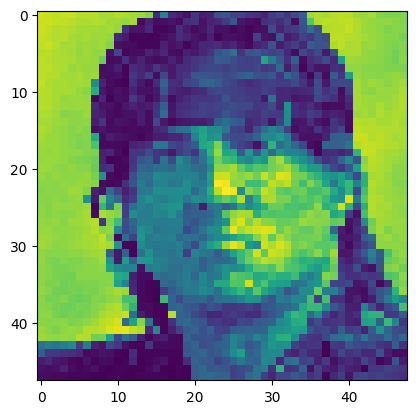

In [45]:
image_test('angry.png')

(48, 48)
1/1 [==============================] - 0s 41ms/step
Surprise


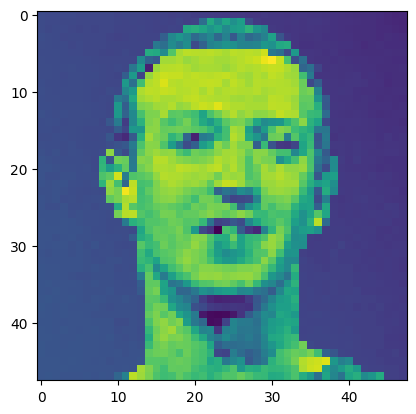

In [57]:
image_test('neutral.png')